# Computer Vision Project: Cheese Classification

Coded by Luna McBride

In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt #plotting
%matplotlib inline

from PIL import Image #Image Processing
import os #Operating System

import tensorflow as tf #Import tensorflow in order to use Keras
from keras import backend as K #Used for trying to clear memory, but I could still not clear enough RAM

from tensorflow.keras.preprocessing.sequence import pad_sequences #Add padding to help the Keras Sequencing
import tensorflow.keras.layers as L #Import the layers as L for quicker typing
from tensorflow.keras.optimizers import Adam #Pull the adam optimizer for usage
from tensorflow.keras.losses import SparseCategoricalCrossentropy #Loss function being used
from tensorflow.keras.preprocessing import image #Add image handling, because I am looking at images

from keras.models import Sequential #Sequential
from keras.layers import Conv2D, MaxPooling2D #Load 2d layers
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization #Load important layers

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/french-cheese-detection/fourmes_train.csv
/kaggle/input/french-cheese-detection/fourmes_test/6.jpg
/kaggle/input/french-cheese-detection/fourmes_test/5.jpg
/kaggle/input/french-cheese-detection/fourmes_test/1.jpg
/kaggle/input/french-cheese-detection/fourmes_test/3.jpeg
/kaggle/input/french-cheese-detection/fourmes_test/4.jpg
/kaggle/input/french-cheese-detection/fourmes_test/2.jpg
/kaggle/input/french-cheese-detection/fourmes_train/45.jpg
/kaggle/input/french-cheese-detection/fourmes_train/56.jpg
/kaggle/input/french-cheese-detection/fourmes_train/20.jpg
/kaggle/input/french-cheese-detection/fourmes_train/6.jpg
/kaggle/input/french-cheese-detection/fourmes_train/5.jpg
/kaggle/input/french-cheese-detection/fourmes_train/8.jpg
/kaggle/input/french-cheese-detection/fourmes_train/22.jpeg
/kaggle/input/french-cheese-detection/fourmes_train/30.jpg
/kaggle/input/french-cheese-detection/fourmes_train/38.jpg
/kaggle/input/french-cheese-detection/fourmes_train/42.jpg
/kaggle/input

In [29]:
cheese = pd.read_csv("../input/french-cheese-detection/fourmes_train.csv", delimiter = ";") #Put the cheese into a dataframe
cheese.head() #Take a peek at the data

,filename,x1,y1,x2,y2,class
0,2.jpg,496,96,1022,678,FourmeDeMontbrison
1,2.jpg,6,95,486,642,FourmeDeMontbrison
2,3.jpg,404,294,522,434,FourmeDeMontbrison
3,4.jpg,112,277,337,537,FourmeDeMontbrison
4,5.jpg,90,4,1059,926,FourmeDAmbert


In [30]:
cheeseTest = pd.read_csv("../input/cheese-test-csv/fourmes_test.csv") #Put the cheese into a dataframe
cheeseTest.head() #Take a peek at the data

,filename,x1,y1,x2,y2,class
0,1.jpg,320,20,700,370,FourmeDeMontbrison
1,2.jpg,50,60,600,700,FourmeDeMontbrison
2,2.jpg,630,90,1170,710,FourmeDAmbert
3,3.jpeg,1480,460,1630,730,FourmeDeMontbrison
4,4.jpg,250,0,530,460,FourmeDeMontbrison


---

# Check for Null Values

In [31]:
print(cheese.isnull().any()) #Check for null values

filename    False
x1          False
y1          False
x2          False
y2          False
class       False
dtype: bool


In [32]:
print(cheeseTest.isnull().any()) #Check for null values

filename    False
 x1         False
 y1         False
 x2         False
 y2         False
 class      False
dtype: bool


---

# Fix Test Set Column Names

In [33]:
colNames = ["filename", "x1", "y1", "x2", "y2", "class"] #List to fix the names since I put spaces in my CSV
cols = dict(zip(cheeseTest.columns, colNames)) #Zip the current names with the new list
cheeseTest = cheeseTest.rename(columns = cols) #Rename the dataframe without the spaces
cheeseTest.head() #Take a peek at the test dataset

,filename,x1,y1,x2,y2,class
0,1.jpg,320,20,700,370,FourmeDeMontbrison
1,2.jpg,50,60,600,700,FourmeDeMontbrison
2,2.jpg,630,90,1170,710,FourmeDAmbert
3,3.jpeg,1480,460,1630,730,FourmeDeMontbrison
4,4.jpg,250,0,530,460,FourmeDeMontbrison


---

# File Name Collecting

In [34]:
files = cheese["filename"].unique() #Get the unique file names

cheese["filenum"] = cheese["filename"].apply(lambda x: x.split(".")[0]) #Put the file number in its own column
cheese.head() #Take a peek at the dataset

,filename,x1,y1,x2,y2,class,filenum
0,2.jpg,496,96,1022,678,FourmeDeMontbrison,2
1,2.jpg,6,95,486,642,FourmeDeMontbrison,2
2,3.jpg,404,294,522,434,FourmeDeMontbrison,3
3,4.jpg,112,277,337,537,FourmeDeMontbrison,4
4,5.jpg,90,4,1059,926,FourmeDAmbert,5


---

# Image Processing

In [35]:
#CropImage: Crops a Pil Image to specified corners (x1, y1) and (x2, y2)
#Input: the image, cornerpoints (x1, y1) and (x2, y2)
#Output: The cropped image
def cropImage(image, x1, y1, x2, y2):
    return image.crop((x1, y1, x2, y2)) #Return the image cropped via (x1, y1) and (x2, y2)

#Standardize: Standarizes images by resizing them to an x by y image
#Input: The image, variables x and y to resize the image to
#Output: The standardized image
def standardize(image, x, y):
    return image.resize((x,y), Image.ANTIALIAS) #Return the resized/standardized image

#PreprocessImages: Pulls image stats from the dataframe to collect, crop, and standardize images, saving them into a new repository
#Input: The dataframe
#Output: A list of processed images and names of their links
def preprocessImages(df, folder):
    croppedImages = [] #A list to hold processed images
    names = [] #A list to hold the link name
    
    directory = "cropped_" + folder #Give the name of the directory
    
    #If the cropped image directory does not exist, make it
    if not os.path.exists(directory):
        os.makedirs(directory) #Make the directory
        
    #For each row, collect the image, crop it, standardize it, and add it to the processed image list
    for index, row in df.iterrows():
        openImage = Image.open("../input/french-cheese-detection/{}/{}".format(folder, row["filename"])) #Open the image
        openImage = cropImage(openImage, row["x1"], row["y1"], row["x2"], row["y2"]) #Crop the image (see the cropImage method)
        stand = standardize(openImage, 60, 60) #Resize/Standardize the image (see the standardize method above)
        croppedImages.append(np.asarray(stand)) #Append the processed image to the holder list
        
        #Build the file path name
        name = "cropped_" + folder + "/" + row["filename"].split(".")[0] + str(row["x1"]) + str(row["y2"]) + "." + row["filename"].split(".")[1]
        names.append("./" + name) #Add the name to the names list
        
        #If the file does not exist, save it.
        if not os.path.isfile(name):
            d = stand.save(name) #Save the new cropped image
        
    return croppedImages, names #Return the list of processed images

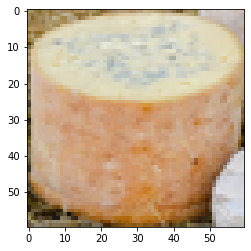

In [36]:
imagesTrain, names = preprocessImages(cheese, "fourmes_train") #Use the preprocessImages function to process images based on the database
plt.imshow(imagesTrain[3]) #Show a processed cheese image (the image processed, not the cheese. We are not working with American here)

A fine cheese indeed.

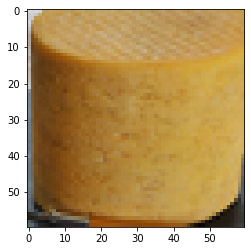

In [37]:
imagesTest, namesTest = preprocessImages(cheeseTest, "fourmes_test") #Use the preprocessImages function to process images based on the database
plt.imshow(imagesTest[4]) #Show a processed cheese image

---

# Set up Train Test Split

In [38]:
classTrain = cheese["class"] #Get the train class we are looking for
classTest = cheeseTest["class"] #Get the test cheese type we are looking for

classTrain = pd.get_dummies(classTrain) #Get dummies for the train set
classTest = pd.get_dummies(classTest) #Get dummies for the test set
print(classTest) #Print one of the sets

    FourmeDAmbert   FourmeDeMontbrison
0               0                    1
1               0                    1
2               1                    0
3               0                    1
4               0                    1
5               0                    1
6               0                    1
7               0                    1


In [40]:
cheese["name"] = names #Put the image names/urls into the cheese dataframe
train_datagen = image.ImageDataGenerator( #Build a image generator
        rescale=1./255, #Resize the images
        shear_range=0.2, #Allow shearing the images
        zoom_range=0.2, #Allow zooming
        horizontal_flip=True) #Allow horizontal flipping

train = train_datagen.flow_from_dataframe(cheese,  #Get the images from the cheese dataframe
        target_size = (60, 60), #Show that image size is to be 60x60
        batch_size = batchSize, #Set the batch size to the pre-determined size
        class_mode = "binary", #Put the mode to binary since there are two labels
        x_col = "name", #Get the image file names into x_col
        y_col = "class") #Get the label classes into y_col

Found 139 validated image filenames belonging to 2 classes.


In [59]:
test_datagen = image.ImageDataGenerator(rescale=1./255) #Build a simple datagen for the test images
cheeseTest["name"] = namesTest #Add the names to the dataframe as to stream them

test = test_datagen.flow_from_dataframe(cheeseTest, #Make a flow variable for keras from the test images
                                        class_mode = "binary", #Make the mode binary since there are only two tiers
                                        x_col = "name", #Get the image names into the x_col
                                        y_col = "class", #Get the labels (cheese type) into the y_col
                                        batch_size = batchSize, #Set the batch size
                                        target_size = (60, 60)) #Show that the target image size is 60x60

Found 8 validated image filenames belonging to 2 classes.


Train and test are already separate. Compare to train test split syntax:

imageTrain, imageTest, classTrain, classTest = train_test_split(images, class, ...)

---

In [62]:
tf.keras.backend.clear_session() #Clear any previous model building

epoch = 50 #Number of runs through the data
width = 60 #The width of the images
height = 60 #The height of the images
channels = 3 #The number of channels (RGB)

model = Sequential() #Add a sequential to the model
model.add(Conv2D(32, (3,3), input_shape = (width, height, channels))) #Add a convolutional image layer
model.add(BatchNormalization()) #Normalize the data
model.add(Activation("relu")) #Make the activation relu to discourage negative units
model.add(MaxPooling2D(pool_size=(2, 2))) #Max pool the data to keep the most important characteristics

model.add(Conv2D(32, (3, 3))) #Add a convolutional image layer
model.add(Activation("relu")) #Make the activation relu to discourage negative units
model.add(MaxPooling2D(pool_size=(2, 2))) #Max pool the data to keep the most important characteristics

model.add(Conv2D(64, (3, 3))) #Add a bigger convolutional image layer, layering activations
model.add(Activation("relu")) #Make the activation relu to discourage negative units
model.add(MaxPooling2D(pool_size=(2, 2))) #Max pool the data to keep the most important characteristics

model.add(Flatten()) #Make the layers flat to apply the characteristics into one slot
model.add(Dense(64)) #Add a dense layer to track activation
model.add(Activation("relu")) #Make the activation relu to discourage negative units
model.add(Dense(1)) #Add another dense layer to finish the lot
model.add(Activation("sigmoid")) #Make the activation sigmoid 

model.compile(loss = "binary_crossentropy", #Make the loss binary to fit with the sigmoid endpoint
              optimizer = "rmsprop", #Use root mean squared prop to optimize (adam came to similar results at much slower speeds)
              metrics = ["accuracy"]) #Track the accuracy of the model

history = model.fit_generator(train, epochs = epoch) #Fit the model to the data

Epoch 1/50
9/9 [==============================] - 0s 44ms/step - loss: 0.6840 - accuracy: 0.7338
Epoch 2/50
9/9 [==============================] - 0s 45ms/step - loss: 0.3947 - accuracy: 0.7842
Epoch 3/50
9/9 [==============================] - 0s 44ms/step - loss: 0.3814 - accuracy: 0.8345
Epoch 4/50
9/9 [==============================] - 0s 45ms/step - loss: 0.4813 - accuracy: 0.7842
Epoch 5/50
9/9 [==============================] - 0s 44ms/step - loss: 0.3000 - accuracy: 0.8777
Epoch 6/50
9/9 [==============================] - 0s 44ms/step - loss: 0.3187 - accuracy: 0.8417
Epoch 7/50
9/9 [==============================] - 0s 45ms/step - loss: 0.3190 - accuracy: 0.8633
Epoch 8/50
9/9 [==============================] - 0s 44ms/step - loss: 0.2817 - accuracy: 0.8633
Epoch 9/50
9/9 [==============================] - 0s 44ms/step - loss: 0.2886 - accuracy: 0.8561
Epoch 10/50
9/9 [==============================] - 0s 44ms/step - loss: 0.2845 - accuracy: 0.8777
Epoch 11/50
9/9 [============

In [80]:
loss, accuracy = model.evaluate(test) #Get the loss and Accuracy based on the tests

#Print the loss and accuracy
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

1/1 [==============================] - 0s 1ms/step - loss: 0.0570 - accuracy: 1.0000
Test Loss:  0.05697357654571533
Test Accuracy:  1.0


In [95]:
classes = ["Fourme d'Ambert", "Fourme de Montbrison"] #Adding the class names
predict = model.predict_classes(test) #Get predictions
print(predict) #Print the predictions

[[1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]]


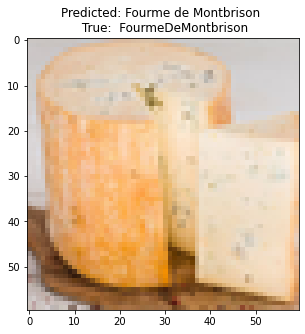

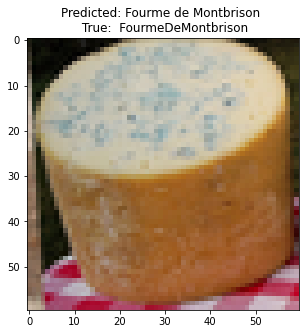

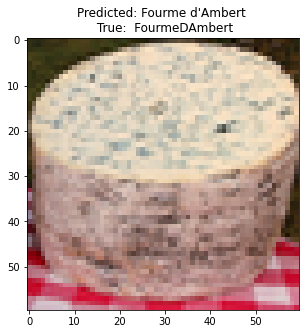

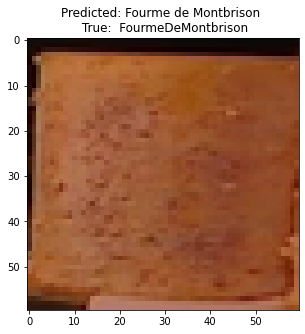

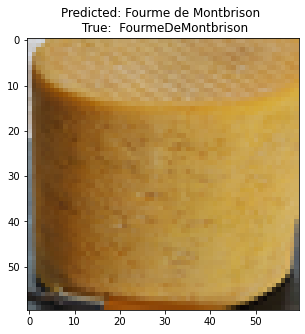

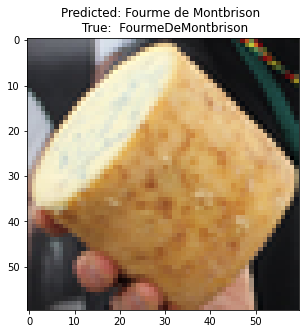

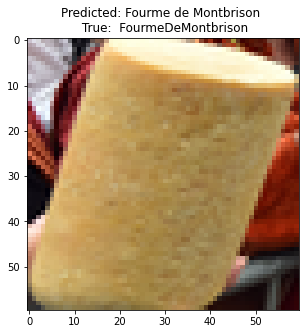

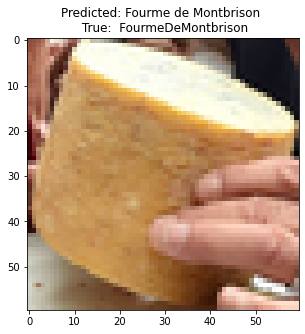

In [106]:
length = len(predict) #Get the length of the predictions
true = cheeseTest["class"] #Get the true names of the cheese

#For each test cheese, print the cheese titled with the prediction
for i in range(0, length):
    plt.figure(figsize = (6, 5)) #Get the cheese picture
    plt.imshow(imagesTest[i]) #Show a processed cheese image
    plt.title("Predicted: {} \n True: {}".format(classes[predict[i][0]], true[i])) #Set the title to the predicted and true cheese names